In [1]:
import sys
import numpy as np

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

In [2]:
'''
Enumerate states for a 3x3 grid ==> 81 states 
(9 choices for pacman location x 9 choices for ghost location)

y    _0_|_1_|_2_
|    _3_|_4_|_5_
v     6 | 7 | 8
    x -->

Each x,y pair represented as an integer number corresponding to the diagram above
'''

states_num = [];

for s in range(81):
    for p in range(9):
        for g in range(9):
            states_num.append( (p, g) )
                    
#for s in range(81):
#    print("state ", s, ": ", states_num[s])

In [3]:
def grid_to_xy(number):
    switch = {
        0: [0,0],
        1: [1,0],
        2: [2,0],
        3: [0,1],
        4: [1,1],
        5: [2,1],
        6: [0,2],
        7: [1,2],
        8: [2,2]
    }
    return switch.get(number, "invalid entry")

def xy_to_grid(x,y):
    switch = {
        0: {0:0, 1:3, 2:6},
        1: {0:1, 1:4, 2:7},
        2: {0:2, 1:5, 2:8}
    }
    x = switch.get(x,"invalid entry")

    if x == "invalid entry":
        return x
    else:
        return x.get(y,"invalid entry")

def return_state(states, p, g):
    return states.index( (p,g) )

def move(x, y, action):
    if action == UP:
        y = max(0, y-1)
    elif action == RIGHT:
        x = min(2, x+1)
    elif action == DOWN:
        y = min(2, y+1)
    elif action == LEFT:
        x = max(0, x-1)
    return xy_to_grid(x, y)

In [4]:
class PacmanEnv:
    '''
    Class to initialize and store information about the Pacman environment for program planning algorithms.

    Properties:
        P[s][a] is a list of is a list of transition tuples (prob, next_state, reward, done)
        num_states = number of states (set to default for 3x3 grid)
        num_actions = number of actions (set to 4)
        pellet_loc = location of pellet (set to 2, i.e. [2,0] by default)

    Methods:
        return_state: Returns state number given location of pacman and the ghost
        move: Moves pacman given current location and action input. Returns grid location number
        calculate_reward: Returns reward for current location of pacman. Used to evaluate R(s,a,s') by 
                        first determining s' through move(s,a), then calculating the reward at s'.
        grid_to_xy: Returns corresponding (x,y) coordinate pair for valid grid location integer input
                    If number out of range, returns 'invalid entry' error message
        xy_to_grid: Returns corresponding grid location # for given (x,y) coordinate pair input
                    If number out of range, returns 'invalid entry' error message
    '''

    def __init__(self, states=states_num, num_states=81, num_actions=4, pellet_loc=2):
        self.states = states
        self.num_states = num_states
        self.num_actions = num_actions
        self.pellet_loc = pellet_loc
        
        P = {s : {a : [] for a in range(num_actions)} for s in range(num_states)}
        
        # parameters must be of the same type, i.e. [x,y] or int value 0-8
        # need to adjust to include reward definition for bumping into walls
        def calculate_reward(pacman_new_loc, ghost_new_loc, ghost_current_loc, pellet_location):
            if pacman_new_loc == ghost_current_loc: # pacman moved to the ghost's location
                return -1000
            elif pacman_new_loc == pellet_location:
                return 1000
            elif pacman_new_loc == ghost_new_loc: # the ghost moved to pacman's new location
                return -1000
            else:
                return 0
        
        for s in range(num_states):
            for pacman_a in range(num_actions):
                done = False # flag to signal game has ended
                temp = P[s][pacman_a]
                pacman_grid_loc = states[s][0] # for the given state, where is pacman
                ghost_grid_loc = states[s][1] # in the given state, where is the ghost
                
                # if pacman performs action a: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
                [x_p, y_p] = grid_to_xy(pacman_grid_loc)
                next_pacman_loc = move(x_p, y_p, pacman_a) # grid location he will move to
                
                for ghost_a in range(num_actions):
                    # if the ghost performs action a: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
                    [x_g, y_g] = grid_to_xy(ghost_grid_loc)
                    next_ghost_loc = move(x_g, y_g, ghost_a) # grid location he will move to
                    
                    # resulting next state, simulates pacman and the ghost moving simultaneously
                    next_state = return_state(states, next_pacman_loc, next_ghost_loc) 
                    reward = calculate_reward(next_pacman_loc, next_ghost_loc, ghost_grid_loc, pellet_loc) # calculate the reward at this state

                    if (pacman_grid_loc == pellet_loc or pacman_grid_loc == ghost_grid_loc):
                        done = True

                    temp.append( (0.25, next_state, reward, done) )
        
        self.P = P
        

In [5]:
def value_iteration(env=PacmanEnv(), gamma=0.9, theta=1e-5):
    '''
    Value Iteration Algorithm

    Inputs:
        env: PacmanEnv as defined in class above.
        gamma: Discount rate for future rewards.
        theta: Stopping criterion value. When change in Value function is less than theta for every state, stop.

    Helper Methods:
        calculate_action_values: Calculates the values for all actions for a given state.
                                Returns a vector action_values of length num_actions, where 
                                action_values[a] = expected value of action a.
                                The expected value is calculated according to the Bellman equation:
                                V(s) = P(s'|s,a) * ( R(s,a) + (gamma * V(s')) )
        extract_policy: Returns the optimal policy for a given value function. It is run once at the end of the algorithm
                        after the optimal V (value function) has been calculated.

    Outputs:
        A tuple (policy, V, steps) of the optimal policy, the approximated optimal value function, and the number of steps
        the algorithm took to converge.
    '''
    
    def calculate_action_values(current_state, V):
        action_values = np.zeros(env.num_actions)
        for a in range(env.num_actions):
            for prob, next_state, reward, done in env.P[current_state][a]:
                action_values[a] += prob * (reward + (gamma * V[next_state]))
        return action_values
    
    def extract_policy(V):
        policy = np.zeros([env.num_states, env.num_actions])
        
        for s in range(env.num_states):
            action_values = calculate_action_values(s, V)
            best_action = np.argmax(action_values) # returns index of action that has maximum V
            policy[s, best_action] = 1 # deterministic optimal policy, i.e. always take best_action for given state
        
        return policy
    
    V = np.zeros(env.num_states) # arbitrarily initialize vector V to be all zeros
    converged = False
    steps = 0
    
    # iteratively calculate optimal V
    while not converged:
        print('Value iteration, step ', steps, '...')
        delta = 0
        for s in range(env.num_states):
            action_values = calculate_action_values(s, V)
            max_action_value = np.max(action_values)
            delta = max( delta, np.abs(max_action_value - V[s]) ) # the maximum difference between V'(s) and V(s) for all s
            V[s] = max_action_value        
        
        steps += 1
        
        #print('Delta: ', delta)
        converged = (delta < theta)
        #print(converged)
    
    # extract optimal policy after calculating optimal V
    policy = extract_policy(V)
    
    return policy, V, steps

In [6]:
import math
winReward = 1000
loseReward = -1000

def nextMove(env, currState, action):
    '''
    Returns all possible next states given action, and the reward given next states.
    ARGS:
        currState: Current game state, ranges from 0 to numStates-1.
        action: Action to perform.
    RETURN:
        nextStates: List of possible next states give current state and action.
                    Largly depends on potential ghost movements.
        rewards: List of rewards for each potential next state.
    '''
    nextStates = [];
    # Get currState coordinates
    
    pacman_grid_loc = env.states[currState][0] # for the given state, where is pacman
    ghost_grid_loc = env.states[currState][1] # in the given state, where is the ghost
                
    [x_p, y_p] = grid_to_xy(pacman_grid_loc)
    [x_g, y_g] = grid_to_xy(ghost_grid_loc)
    
    # Get pacman location after performing action
    next_pacman_loc = move(x_p, y_p, action)
    pacmanLocX_next, pacmanLocY_next = grid_to_xy(next_pacman_loc)
    
    # Initialize rewards
    if (next_pacman_loc == env.pellet_loc): 
        rewards = [winReward]*4;
    elif (next_pacman_loc == ghost_grid_loc):
        rewards = [loseReward]*4;
    else:
        rewards = [0]*4;

    # Iterate through possible ghost states
    for ghostAction in range(4):
        next_ghost_loc = move(x_g, y_g, ghostAction)
        ghostLocX_next, ghostLocY_next = grid_to_xy(next_ghost_loc)
        state = return_state(env.states, next_pacman_loc, next_ghost_loc)
        nextStates.append(state);     
        # Evaluate reward - pacman eaten by ghost
        if (next_pacman_loc == next_ghost_loc):
            rewards[ghostAction] = loseReward;

    return nextStates, rewards;

In [7]:
import math
winReward = 1000
loseReward = -1000

###############################################################################
############################  Policy Iteration ################################
###############################################################################
def policy_iteration(env=PacmanEnv(), deltaLim=1e-5, gamma=0.9):
    '''
    Policy iteration algorithm consists of two steps that are repeated in each iteration of the loop:
    policy evaluation (calculate V) and policy improvement (greedy approach to improve current policy).
    
    Helper Methods:
        policyEvaluation
        policyImprovement
    '''
    prob = 0.25
    
    ########################## Policy evaluation ##################################
    def policyEvaluation(policy, v, deltaLim=1e-5, delta=10000):
        cnt = 0;
        while (delta > deltaLim): 
            delta = 0;
            for state in range(env.num_states):
                if (env.P[state][0][0][3] == True): # game has ended
                    v[state] = 0;
                    continue;
                vStateOld = v[state]; 
                # Choose action from policy
                action = policy[state];
                # Potential next states given current state and action
                nextStates, rewards = nextMove(env, state, action); 
                # Compute V(s)
                vNextStates = [prob*(rewards[i]+gamma*v[nextStates[i]]) for i in range(len(nextStates))];
                v[state] = sum(vNextStates);

                delta = max(delta, abs(v[state]-vStateOld));
            print("Delta",delta);
            cnt += 1;
        print("Policy evalulation converged at", cnt);
        return v;


    ########################## Policy Improvement #################################
    def policyImprovement(policy, v):
        policyStable = True;
        for state in range(env.num_states):
            if (env.P[state][0][0][3] == True): # game ended
                continue;
            oldAction = policy[state];
            # Optimal action and V(s,a)
            optAction = 0; 
            optActionVal = None;
            for action in range(4):
                # Potential next states given current state and action
                nextStates, rewards = nextMove(env, state, action);
                # Compute V(s,a)
                vNextStates = [prob*(rewards[i]+gamma*v[nextStates[i]]) for i in range(len(nextStates))];
                actionVal = sum(vNextStates);
                if (optActionVal == None):
                    optActionVal = actionVal;
                if (actionVal > optActionVal): # Choose action with largest V(s,a)
                    optActionVal = actionVal;
                    optAction = action;
            # No convergence
            if (oldAction != optAction):
                policyStable = False;
                policy[state] = optAction;
        return policy, policyStable
    
    # Init
    v = [0]*env.num_states;
    policy = [0]*env.num_states;
    policyStable = False;

    # Run Policy Iteration
    policyIter = 1;
    while (not policyStable):
        v = policyEvaluation(policy, v);
        policy, policyStable = policyImprovement(policy, v);
        # print("Total iterations:", policyIter)
        policyIter += 1;

    return policy, v, policyIter

In [8]:
# intervals of 0.05
# note: algo runs for a long time if gamma=0 or 1
gammas = np.arange(0.05,1,0.05) # np.arange includes the lower bound, excludes upper bound
# print(gammas)

convergence_steps = []

for g in range(len(gammas)):
    policy, V, steps = policy_iteration(gamma=gammas[g])
    convergence_steps.append(steps)

print(convergence_steps)

Delta 1012.8145266017914
Delta 6.328131103515602
Delta 0.19777221679686363
Delta 0.005519269943249583
Delta 0.0001470095038484942
Delta 3.836860230421735e-06
Policy evalulation converged at 6
Delta 1256.4925048331042
Delta 56.41538492483041
Delta 0.3638691620477696
Delta 0.003819299061346426
Delta 5.9124867072312196e-05
Delta 8.996714863721e-07
Policy evalulation converged at 6
Delta 49.35896372133762
Delta 1.4841264041018412
Delta 0.009893641434108646
Delta 0.00030930285487268394
Delta 7.805206445721247e-06
Policy evalulation converged at 5
Delta 0.3808633854366117
Delta 0.004760792344945558
Delta 5.969694750118659e-05
Delta 1.5377280165804197e-06
Policy evalulation converged at 4
Delta 1.1112415737590808e-08
Policy evalulation converged at 1
Delta 1026.2668045654298
Delta 12.812597656249977
Delta 0.8010742187499886
Delta 0.04536706542972979
Delta 0.002462908935513042
Delta 0.00013139742685552847
Delta 6.961227143165161e-06
Policy evalulation converged at 7
Delta 1263.5052925517693
De

Delta 1387.0276594443928
Delta 529.0101688324031
Delta 63.508245303366266
Delta 6.2167016214711275
Delta 1.3573447553642666
Delta 0.36158195762776124
Delta 0.10581921700648067
Delta 0.030817525021932468
Delta 0.008958330887889332
Delta 0.00260202087957051
Delta 0.0007555262086134107
Delta 0.0002193545781068451
Delta 6.368810979040518e-05
Delta 1.8493360830262873e-05
Delta 5.370772058199691e-06
Policy evalulation converged at 15
Delta 383.6504499740884
Delta 99.87612945943361
Delta 8.248143960904173
Delta 2.40667218688705
Delta 0.6123642996063268
Delta 0.15378815943905266
Delta 0.037841305863949515
Delta 0.009203847619588146
Delta 0.0022270753754796146
Delta 0.000537869237135169
Delta 0.00012986760068400827
Delta 3.137338683956159e-05
Delta 7.586297833483968e-06
Policy evalulation converged at 13
Delta 23.867852255376633
Delta 2.685133400361636
Delta 0.37997259400674466
Delta 0.09963810202290091
Delta 0.013581615778953449
Delta 0.0036389628743620506
Delta 0.0009179218368444708
Delta 0.0

Delta 152.29826173710285
Delta 6.346010355930332
Delta 1.5789627270451376
Delta 0.5965366664229066
Delta 0.14923177344218175
Delta 0.0618747787967493
Delta 0.024106123537706026
Delta 0.008981505472945628
Delta 0.003253847212022265
Delta 0.0011567698354042477
Delta 0.0004058092874856811
Delta 0.00014099456973326596
Delta 4.863758070428048e-05
Delta 1.668782584829387e-05
Delta 5.702233579540916e-06
Policy evalulation converged at 15
Delta 1.9423251274020004e-06
Policy evalulation converged at 1
Delta 1244.5892293701172
Delta 103.04697265625003
Delta 45.68388671874999
Delta 21.36887487792967
Delta 10.131534167480538
Delta 4.931694141306593
Delta 2.47021527140879
Delta 1.296400009320223
Delta 0.733731498577896
Delta 0.4127341432201348
Delta 0.23110021290527527
Delta 0.1289472882458398
Delta 0.07175739814805127
Delta 0.039850535241782836
Delta 0.022096253055082116
Delta 0.01223699594009986
Delta 0.006770497580930623
Delta 0.0037432272025625934
Delta 0.0020683355847666007
Delta 0.00114234850

Delta 0.7492239503111477
Delta 0.5410521213288177
Delta 0.39055786261249636
Delta 0.2818352716626009
Delta 0.20333033379512244
Delta 0.1466663861176869
Delta 0.10577891581840504
Delta 0.07628193183109033
Delta 0.05500584874187098
Delta 0.039661461626593564
Delta 0.028596136871726685
Delta 0.020617193599321126
Delta 0.01502809220963286
Delta 0.011104270998146148
Delta 0.00820496181606245
Delta 0.006062660896077432
Delta 0.004479712270750724
Delta 0.003310069002424143
Delta 0.002445817388490923
Delta 0.0018072200837480068
Delta 0.0013353591386078278
Delta 0.0009867000179326624
Delta 0.0007290749869071078
Delta 0.0005387152471598711
Delta 0.00039805798485303967
Delta 0.00029412599903366754
Delta 0.00021733040645699475
Delta 0.0001605859591791159
Delta 0.00011865735103810948
Delta 8.767620181515667e-05
Delta 6.478415625110756e-05
Delta 4.786916883858794e-05
Delta 3.5370643900023424e-05
Delta 2.6135453822462296e-05
Delta 1.931154972112381e-05
Delta 1.4269350486983967e-05
Delta 1.05436573676

Delta 0.0002778012298563226
Delta 0.00024105667120011276
Delta 0.00020917228749794958
Delta 0.00018150522708992867
Delta 0.0001574976679989959
Delta 0.00013666557043734429
Delta 0.00011858891872407185
Delta 0.00010290325212736207
Delta 8.929231677257121e-05
Delta 7.74816895159347e-05
Delta 6.72332450903923e-05
Delta 5.834035448515351e-05
Delta 5.062371991471082e-05
Delta 4.3927758781592274e-05
Delta 3.8117467283882434e-05
Delta 3.307569869548388e-05
Delta 2.8700801124159625e-05
Delta 2.490456779469241e-05
Delta 2.1610459384646674e-05
Delta 1.875206032764254e-05
Delta 1.6271739468720625e-05
Delta 1.4119488810138137e-05
Delta 1.2251914654370921e-05
Delta 1.0631363124957716e-05
Delta 9.225160852111003e-06
Policy evalulation converged at 112
Delta 2228.652341935713
Delta 1613.0901230075247
Delta 218.84327008725944
Delta 134.6626536464355
Delta 86.4988973302074
Delta 58.01401147664399
Delta 45.59541576412308
Delta 37.76429366686808
Delta 31.16150020911894
Delta 25.675514768072446
Delta 21.1

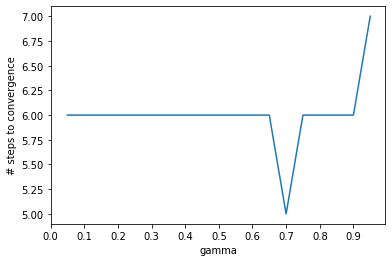

In [10]:
import matplotlib.pyplot as plt

plt.plot(gammas, convergence_steps)
plt.xlabel('gamma')
plt.ylabel('# steps to convergence')
plt.xticks(np.arange(0,1,0.1))
plt.show()